In [ ]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.manifold import TSNE
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


✓ All libraries imported successfully!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

data = {
    'bio':     pd.read_csv('/content/drive/MyDrive/data clu/biology.csv',  index_col=0),
    'cooking':    pd.read_csv('/content/drive/MyDrive/data clu/cooking.csv', index_col=0),
    'cryp':    pd.read_csv('/content/drive/MyDrive/data clu/crypto.csv',   index_col=0),
    'diy':     pd.read_csv('/content/drive/MyDrive/data clu/diy.csv',      index_col=0),
    'robo': pd.read_csv('/content/drive/MyDrive/data clu/robotics.csv',  index_col=0),
    'travel':  pd.read_csv('/content/drive/MyDrive/data clu/travel.csv',   index_col=0)}

frames = []
for domain, df_topic in data.items():
    df_topic = df_topic.copy()
    # Add the 'domain' column to each DataFrame before concatenation
    df_topic['domain'] = domain
    frames.append(df_topic)

df= pd.concat(frames, ignore_index=True)

In [ ]:
df.shape

(87000, 4)

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/data clu/biology.csv',     index_col=0),


In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt

print("=== Shape ===")
print(df.shape)

print("\n=== Columns ===")
print(df.columns)

print("\n=== dtypes ===")
print(df.dtypes)

print("\n=== Missing values per column ===")
print(df.isna().sum())

# Drop rows with missing content
df = df.dropna(subset=["content"])

# Drop duplicate titles (questions)
df = df.drop_duplicates(subset=["title"])

# Reset index and add doc_id
df = df.reset_index(drop=True)
df["doc_id"] = df.index

print("\n=== Shape after cleaning missing+dupes ===")
print(df.shape)


=== Shape ===
(87000, 4)

=== Columns ===
Index(['title', 'content', 'tags', 'domain'], dtype='object')

=== dtypes ===
title      object
content    object
tags       object
domain     object
dtype: object

=== Missing values per column ===
title      0
content    0
tags       0
domain     0
dtype: int64

=== Shape after cleaning missing+dupes ===
(86968, 5)


In [ ]:
def strip_html(text):
    return BeautifulSoup(str(text), "html.parser").get_text(" ", strip=True)

df["clean_title"] = df["title"].apply(strip_html)
df["clean_content"] = df["content"].apply(strip_html)

# Combine for later clustering
df["raw_text"] = df["clean_title"] + " " + df["clean_content"]


In [ ]:
orig_n = df.shape[0]
df["text_len_chars"] = df["raw_text"].str.len()

print("\n=== Text length stats (chars) ===")
print(df["text_len_chars"].describe())

min_len = 50
df_filtered = df[df["text_len_chars"] >= min_len].reset_index(drop=True)
df_filtered["doc_id"] = df_filtered.index

print("\n=== Shape after removing very short docs (< 50 chars) ===")
print(df_filtered.shape)

removed = orig_n - df_filtered.shape[0]
print(f"\nRemoved {removed} very short documents (shorter than {min_len} chars).")



=== Text length stats (chars) ===
count    86968.000000
mean       655.155505
std        571.115834
min         40.000000
25%        328.000000
50%        509.000000
75%        796.000000
max      20787.000000
Name: text_len_chars, dtype: float64

=== Shape after removing very short docs (< 50 chars) ===
(86967, 9)

Removed 1 very short documents (shorter than 50 chars).


In [ ]:
import numpy as np

print("\n=== Sample rows ===")
print(df[["doc_id", "clean_title", "tags"]].head())

tag_series = (
    df["tags"]
    .fillna("")                  # remove NaN
    .astype(str)
    .str.strip()
    .replace("", np.nan)         # convert empty to NaN
    .dropna()
    .str.split()
    .explode()
)

print("\n=== Top 20 tags ===")
print(tag_series.value_counts().head(20))



=== Sample rows ===
   doc_id                                        clean_title  \
0       0  What is the criticality of the ribosome bindin...   
1       1  How is RNAse contamination in RNA based experi...   
2       2      Are lymphocyte sizes clustered in two groups?   
3       3  How long does antibiotic-dosed LB maintain goo...   
4       4        Is exon order always preserved in splicing?   

                                                tags  
0  ribosome binding-sites translation synthetic-b...  
1                                   rna biochemistry  
2                 immunology cell-biology hematology  
3                                       cell-culture  
4            splicing mrna spliceosome introns exons  

=== Top 20 tags ===
tags
electrical                 4489
visas                      3828
air-travel                 2272
plumbing                   2223
usa                        2168
encryption                 1777
wiring                     1680
schengen      

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download("stopwords")
nltk.download("wordnet")

# 1) Base stopwords
stop_words = set(stopwords.words("english"))

# 2) Add custom stopwords
custom_stopwords = {
    "would", "one", "two", "like", "question", "know", "get", "make",
    "way", "need", "use", "could", "time", "etc"
}
stop_words = stop_words.union(custom_stopwords)

lemm = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)

    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    tokens = [lemm.lemmatize(t) for t in tokens]

    return " ".join(tokens)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
df["clean_final"] = df["raw_text"].apply(clean_text)
df["clean_len"] = df["clean_final"].str.split().str.len()



=== Word count stats BEFORE cleaning ===
count    86968.000000
mean       117.020157
std         94.435137
min          9.000000
25%         60.000000
50%         92.000000
75%        143.000000
max       2749.000000
Name: raw_word_count, dtype: float64

=== Word count stats AFTER cleaning ===
count    86968.000000
mean        54.879634
std         47.694324
min          3.000000
25%         28.000000
50%         43.000000
75%         67.000000
max       2251.000000
Name: clean_len, dtype: float64


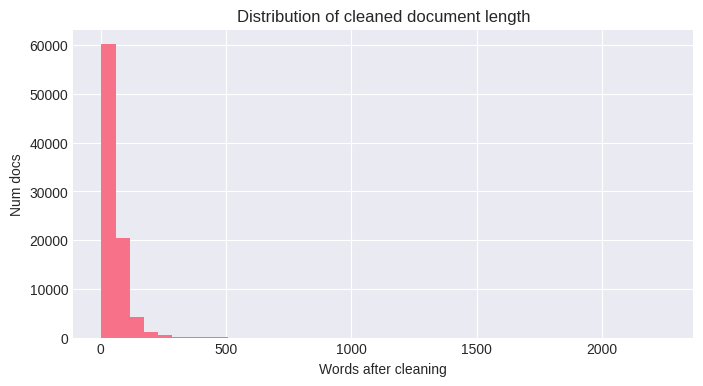

In [ ]:
print("\n=== Word count stats BEFORE cleaning ===")
df["raw_word_count"] = df["raw_text"].str.split().str.len()
print(df["raw_word_count"].describe())

print("\n=== Word count stats AFTER cleaning ===")
print(df["clean_len"].describe())

plt.figure(figsize=(8,4))
df["clean_len"].hist(bins=40)
plt.xlabel("Words after cleaning")
plt.ylabel("Num docs")
plt.title("Distribution of cleaned document length")
plt.show()

In [ ]:
from sentence_transformers import SentenceTransformer
import torch

sbert_model = SentenceTransformer("all-mpnet-base-v2",device="cuda")

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df_train = df[df["domain"] != "test"].reset_index(drop=True)
print("Train shape:", df_train.shape)
print(df_train["domain"].value_counts())

Train shape: (86968, 12)
domain
diy        25908
travel     19275
cooking    15402
bio        13190
cryp       10424
robo        2769
Name: count, dtype: int64


In [ ]:
texts = df["clean_final"].astype(str).tolist()

embeddings = sbert_model.encode(
    texts,
    batch_size=64,           # reduce if OOM
    show_progress_bar=True,
    convert_to_numpy=True,
    device="cuda"
)

print("Embeddings shape:", embeddings.shape)   # (n_docs, 768)


Batches:   0%|          | 0/1359 [00:00<?, ?it/s]

Embeddings shape: (86968, 768)


In [ ]:
import umap.umap_ as umap

# 10D for clustering
umap_clust = umap.UMAP(
    n_neighbors=50,
    min_dist=0.0,
    n_components=10,
    metric="cosine",
    random_state=42
)

X_umap_clust = umap_clust.fit_transform(embeddings)
print("UMAP (10D) shape:", X_umap_clust.shape)

umap_vis = umap.UMAP(
    n_neighbors=30,
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    random_state=42
)

X_umap_2d = umap_vis.fit_transform(embeddings)


UMAP (10D) shape: (86968, 10)


In [ ]:
import cudf
from cuml.cluster import KMeans
from cuml.metrics.cluster import silhouette_score  # Corrected import path based on cuml documentation
import pandas as pd

results = []
K_values = range(2, 15)

# Convert embeddings (numpy or pandas) to cuDF for GPU
gdf = cudf.DataFrame.from_pandas(pd.DataFrame(embeddings))

for k in K_values:
    print(f"Fitting cuML KMeans with k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(gdf)

    # GPU silhouette
    sil = float(silhouette_score(gdf, labels))

    from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
    labels_cpu = labels.to_numpy()
    db = davies_bouldin_score(embeddings, labels_cpu)
    ch = calinski_harabasz_score(embeddings, labels_cpu)
    inertia = kmeans.inertia_

    results.append({
        "k": k,
        "silhouette": sil,
        "davies_bouldin": db,
        "calinski_harabasz": ch,
        "inertia": inertia
    })

metrics_gpu = pd.DataFrame(results)
print(metrics_gpu)

Fitting cuML KMeans with k=2...
Fitting cuML KMeans with k=3...
Fitting cuML KMeans with k=4...
Fitting cuML KMeans with k=5...
Fitting cuML KMeans with k=6...
Fitting cuML KMeans with k=7...
Fitting cuML KMeans with k=8...
Fitting cuML KMeans with k=9...
Fitting cuML KMeans with k=10...
Fitting cuML KMeans with k=11...
Fitting cuML KMeans with k=12...
Fitting cuML KMeans with k=13...
Fitting cuML KMeans with k=14...
     k  silhouette  davies_bouldin  calinski_harabasz       inertia
0    2    0.022472        4.883731        2235.957275  78232.546875
1    3    0.028853        5.533213        2116.587158  76519.921875
2    4    0.036904        4.782581        2026.703857  75000.585938
3    5    0.036012        4.567292        1841.493896  73978.179688
4    6    0.043382        4.366873        1847.735840  72538.054688
5    7    0.044937        4.349292        1708.485962  71782.625000
6    8    0.045058        4.236020        1598.602173  71095.523438
7    9    0.039564        4.596890 

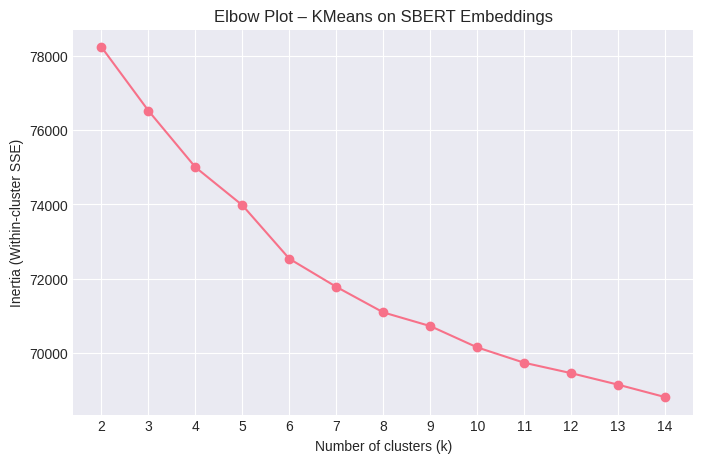

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(metrics_gpu["k"], metrics_gpu["inertia"], marker="o")
plt.xticks(metrics_gpu["k"])
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (Within-cluster SSE)")
plt.title("Elbow Plot – KMeans on SBERT Embeddings")
plt.grid(True)
plt.show()


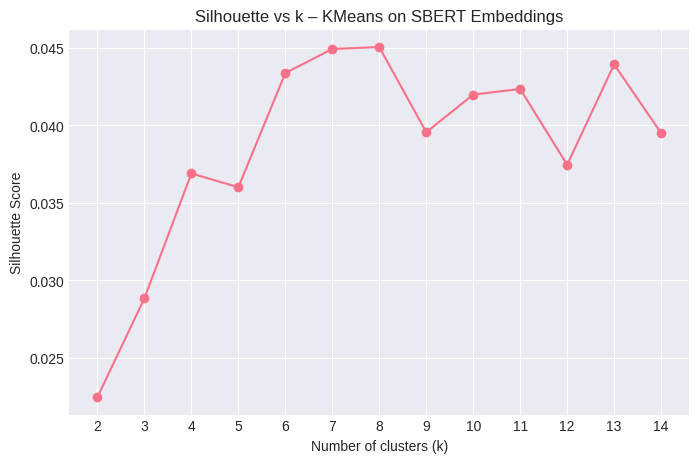

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(metrics_gpu["k"], metrics_gpu["silhouette"], marker="o")
plt.xticks(metrics_gpu["k"])
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette vs k – KMeans on SBERT Embeddings")
plt.grid(True)
plt.show()


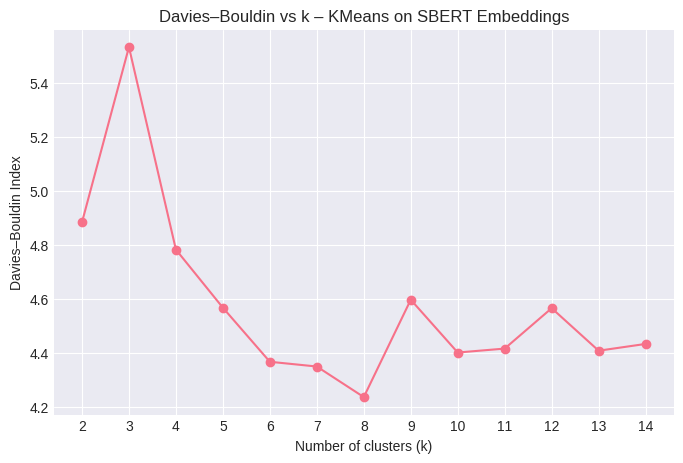

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(metrics_gpu["k"], metrics_gpu["davies_bouldin"], marker="o")
plt.xticks(metrics_gpu["k"])
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Index")
plt.title("Davies–Bouldin vs k – KMeans on SBERT Embeddings")
plt.grid(True)
plt.show()


In [ ]:
k_best = 6

from sklearn.cluster import KMeans

kmeans_final = KMeans(n_clusters=k_best, random_state=42, n_init="auto")
df_train["cluster_sbert"] = kmeans_final.fit_predict(X_umap_clust)
df_train["cluster_sbert"].value_counts()




,count
cluster_sbert,
4,26050
3,18951
5,15801
2,13048
0,10440
1,2678


In [ ]:
from sklearn.metrics import accuracy_score, normalized_mutual_info_score, adjusted_rand_score

# Majority domain per cluster
cluster_majority = df_train.groupby("cluster_sbert")["domain"].agg(lambda x: x.value_counts().index[0])

df_train["pred_majority_domain"] = df_train["cluster_sbert"].map(cluster_majority)

purity = accuracy_score(df_train["domain"], df_train["pred_majority_domain"])
nmi = normalized_mutual_info_score(df_train["domain"], df_train["cluster_sbert"])
ari = adjusted_rand_score(df_train["domain"], df_train["cluster_sbert"])

print("Purity:", purity)
print("NMI:", nmi)
print("ARI:", ari)

print("\nDomain vs Cluster (SBERT+UMAP):")
print(pd.crosstab(df_train["domain"], df_train["cluster_sbert"]))


Purity: 0.9811079937448257
NMI: 0.933840832767469
ARI: 0.9557731898796828

Domain vs Cluster (SBERT+UMAP):
cluster_sbert      0     1      2      3      4      5
domain                                                
bio               16    17  12673     20     58    406
cooking            0     1     54     17    170  15160
cryp           10406     3      6      4      4      1
diy                3    30    194     12  25576     93
robo              12  2616     18      4    100     19
travel             3    11    103  18894    142    122


In [ ]:
import numpy as np

for c in sorted(df_train["cluster_sbert"].unique()):
    print(f"\n=== Cluster {c} — Top Tags ===")
    tags = (
        df_train[df_train["cluster_sbert"] == c]["tags"]
        .fillna("")
        .astype(str)
        .str.strip()
        .replace("", np.nan)
        .dropna()
        .str.split()
        .explode()
    )
    print(tags.value_counts().head(20))



=== Cluster 0 — Top Tags ===
tags
encryption                 1773
hash                       1138
rsa                        1095
aes                         922
public-key                  842
cryptanalysis               739
elliptic-curves             575
signature                   456
block-cipher                434
algorithm-design            381
protocol-design             378
random-number-generator     359
diffie-hellman              335
keys                        322
authentication              319
symmetric                   302
homomorphic-encryption      297
provable-security           276
hmac                        271
reference-request           262
Name: count, dtype: int64

=== Cluster 1 — Top Tags ===
tags
quadcopter         304
mobile-robot       280
arduino            260
control            245
motor              225
sensors            197
robotic-arm        175
pid                161
localization       125
slam               114
microcontroller    108
ros        

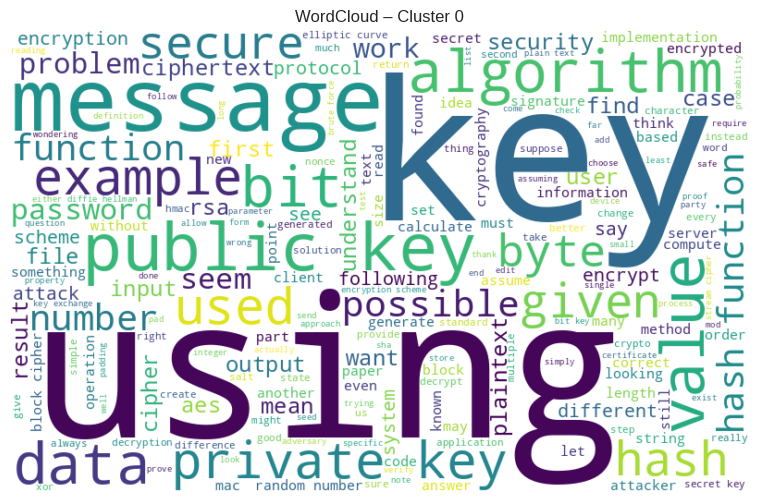

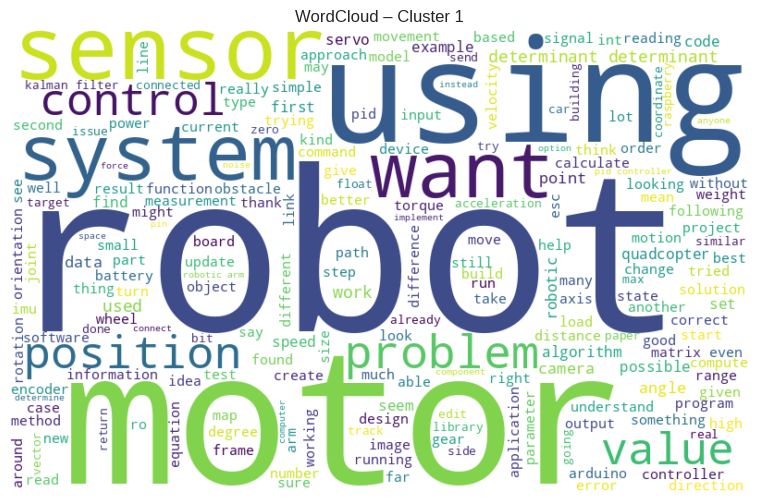

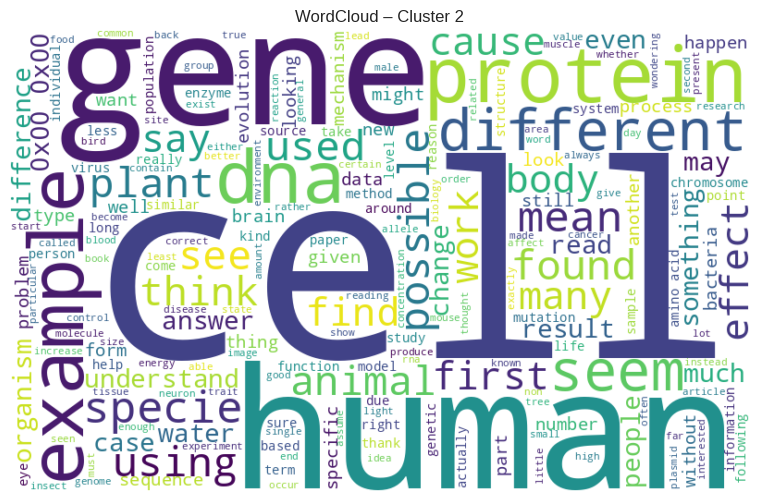

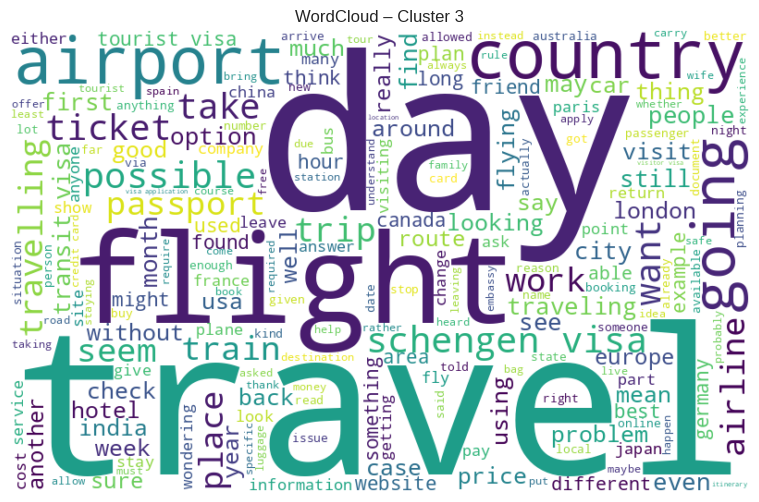

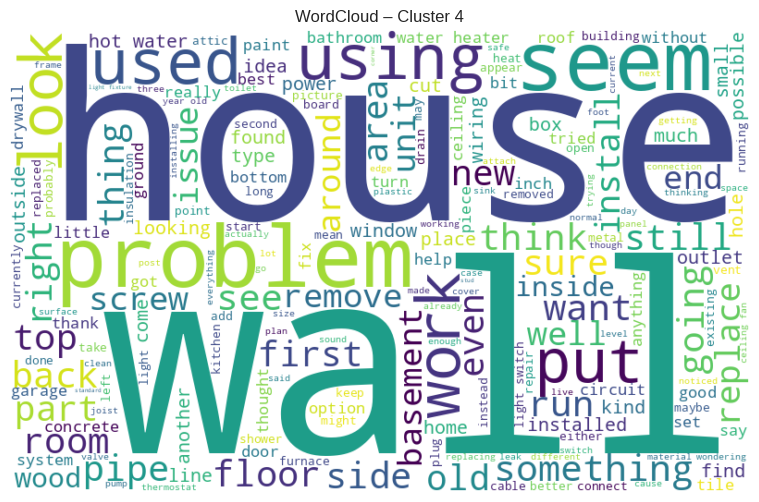

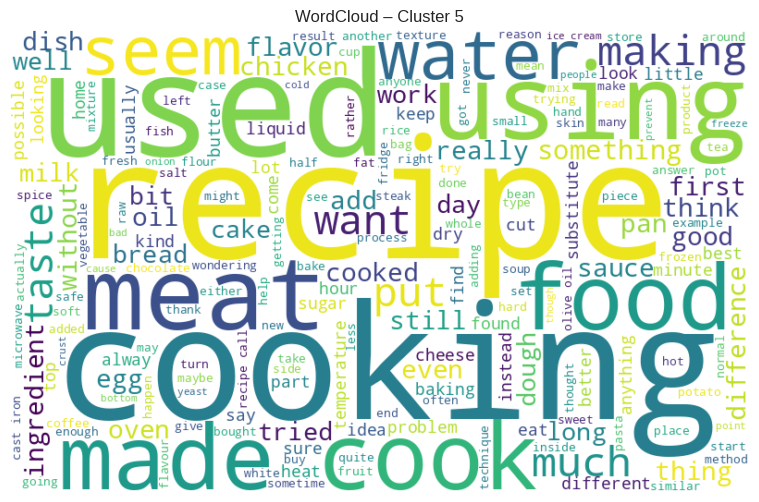

In [ ]:
from wordcloud import WordCloud

for c in sorted(df_train["cluster_sbert"].unique()):
    cluster_text = " ".join(df_train[df_train["cluster_sbert"] == c]["clean_final"])

    wc = WordCloud(
        width=800,
        height=500,
        background_color="white",
        max_words=200
    ).generate(cluster_text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud – Cluster {c}")
    plt.show()


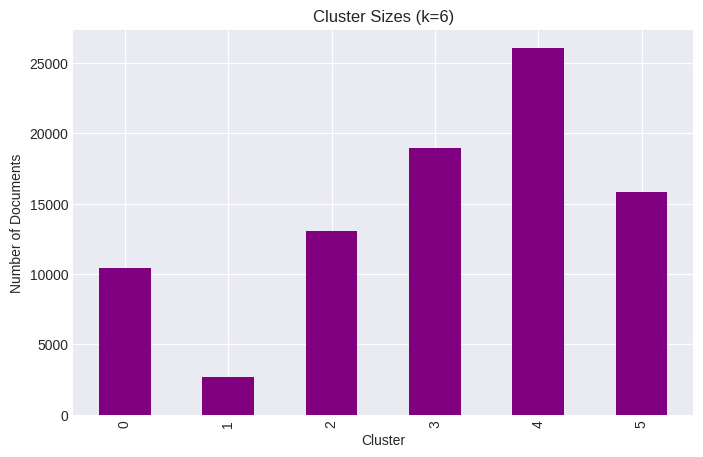

In [ ]:
plt.figure(figsize=(8, 5))
df_train["cluster_sbert"].value_counts().sort_index().plot(kind='bar', color='purple')
plt.title("Cluster Sizes (k=6)")
plt.xlabel("Cluster")
plt.ylabel("Number of Documents")
plt.show()


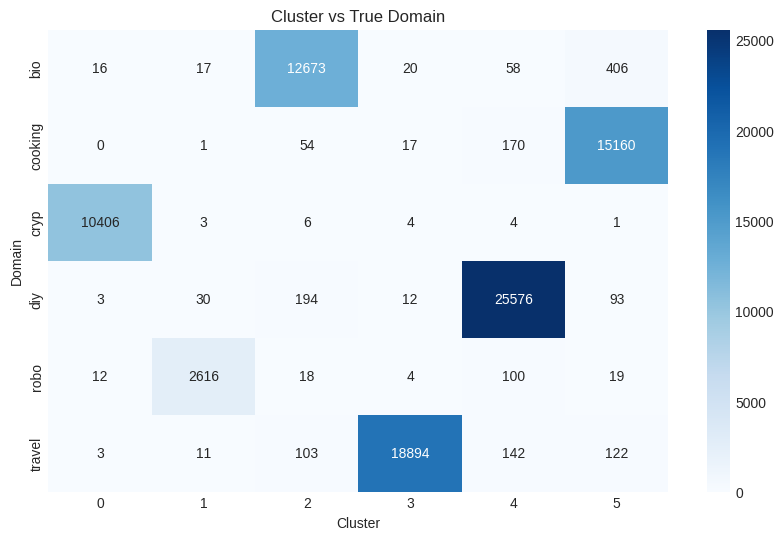

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

ct = pd.crosstab(df_train["domain"], df_train["cluster_sbert"])

plt.figure(figsize=(10, 6))
sns.heatmap(ct, annot=True, fmt="d", cmap="Blues")
plt.title("Cluster vs True Domain")
plt.xlabel("Cluster")
plt.ylabel("Domain")
plt.show()


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf_train = TfidfVectorizer(
    max_features=30000,
    min_df=3,
    max_df=0.9,
    ngram_range=(1,2)
)

X_tfidf_train = tfidf_train.fit_transform(df["clean_final"])
vocab = np.array(tfidf_train.get_feature_names_out())

TOP_N = 20

for c in sorted(df_train["cluster_sbert"].unique()):
    print(f"\n=== Cluster {c} — Top {TOP_N} TF-IDF Terms ===")
    mask = (df_train["cluster_sbert"] == c).values
    X_c = X_tfidf_train[mask]

    mean_tfidf = np.asarray(X_c.mean(axis=0)).ravel()
    top_idx = mean_tfidf.argsort()[::-1][:TOP_N]
    print(vocab[top_idx])



=== Cluster 0 — Top 20 TF-IDF Terms ===
['key' 'encryption' 'hash' 'message' 'bit' 'cipher' 'algorithm' 'rsa'
 'function' 'aes' 'random' 'public' 'number' 'using' 'data' 'attack'
 'secure' 'password' 'value' 'encrypted']

=== Cluster 1 — Top 20 TF-IDF Terms ===
['robot' 'motor' 'sensor' 'using' 'control' 'arduino' 'servo' 'position'
 'controller' 'robotics' 'camera' 'pid' 'arm' 'system' 'quadcopter'
 'wheel' 'angle' 'battery' 'speed' 'data']

=== Cluster 2 — Top 20 TF-IDF Terms ===
['cell' 'human' 'dna' 'gene' 'protein' 'specie' 'plant' 'body' 'animal'
 'blood' 'sequence' 'brain' 'different' 'organism' 'example' 'chromosome'
 'bacteria' 'also' 'effect' 'biology']

=== Cluster 3 — Top 20 TF-IDF Terms ===
['visa' 'flight' 'travel' 'passport' 'airport' 'day' 'ticket' 'country'
 'schengen' 'visit' 'trip' 'train' 'month' 'transit' 'card' 'citizen'
 'airline' 'stay' 'travelling' 'car']

=== Cluster 4 — Top 20 TF-IDF Terms ===
['wall' 'water' 'wire' 'light' 'house' 'switch' 'floor' 'door' 'p

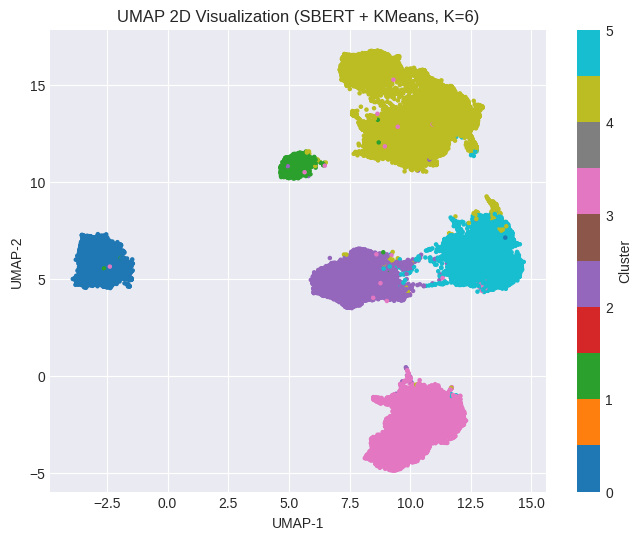

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_umap_2d[:,0], X_umap_2d[:,1],
    c=df_train["cluster_sbert"],
    cmap="tab10",
    s=5
)
plt.title(f"UMAP 2D Visualization (SBERT + KMeans, K={int(k_best)})")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.colorbar(scatter, label="Cluster")
plt.show()


In [ ]:
for c in sorted(df_train["cluster_sbert"].unique()):
    print(f"\n=== Cluster {c} — Sample Questions ===")
    subset = df_train[df_train["cluster_sbert"] == c].sample(5, random_state=42)
    for _, row in subset.iterrows():
        print(f"{row['clean_title']}")
        print(f"{row['clean_content']}")
    print("-" * 80)



=== Cluster 0 — Sample Questions ===
How much work is required to detect multiple collisions for a hash function?
Assume an ideal hash function of output size n bits, detecting one collision requires approximately 2^(n/2) evaluations of the hash function using a birthday attack. However, how many evaluations are required to produce two or more collisions? Note I am talking about distinct collisions i.e. $H(A)=H(B)$, $H(C)=H(D)$, etc.
Can homomorphic encryption filter?
Often in articles homomorphic encryption is praised as the holy grail of encryption for cloud storage. This is done by suggesting that it can do any computation, and as such could be used for encrypted databases. Performance issues aside, this makes me very sceptical. If such a database is to be any useful you need to be able to do queries. I understand how these work and how you could do the tricks needed to transform a query into a circuit. However such a circuit only does a modification on the data, but it does not re